In [222]:
%load_ext autoreload
%autoreload 2
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat
from penalties import penalize_barriers, get_penalties, penalize_barriers_seq, pairing_frequency, penalize_barriers_ensemble

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

# Create dummy data with no constraints
shape_data['kinetic20'] = {}
shape_data['no_constraints'] = {}
for l in shape_data['BZCN_0001']:
    shape_data['kinetic20'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
    shape_data['no_constraints'][l] = {
        'seq' : shape_data['BZCN_0001'][l]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][l]['seq']))]
    }
#d = parse_rdat('SRP_test/SRPECLI_BZCN_0001.rdat.txt')
md = RNA.md()
md.temperature = 37 #Both transcription and modification was done at 37

In [175]:
# Calculate folding pathways for each dataset
last_structure = ''
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        # Shape-defined fold
        fc = RNA.fold_compound(subseq, md)
        if n not in ['no_constraints', 'kinetic20']:
            #fc.sc_add_SHAPE_deigan(reactivities, 2.6, -0.8)
            fc.sc_add_SHAPE_zarringhalam(reactivities, 0.8, 0.5, 'M')
        if n == 'kinetic20':
            step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : 20
            }
            fc.sc_add_f(penalize_barriers)
            fc.sc_add_data(step_info)
        d[length]['mfe'] = fc.mfe()[0]
        last_structure = d[length]['mfe']


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003
Working on kinetic20
Working on no_constraints


In [176]:
# also try drtransformer
print("Working on drtransformer")
shape_data['drtransformer'] = {}
name = 'SRP_drt'
#subprocess.run(['cat', 'SRP_test/SRP.fa', '|', 'DrTransformer' '--name', f'{name}', '--logfile'], shell=True, check=True) # this doesn't work for some reason

with open(f'SRP_test/{name}.log', 'r') as f:
    lines = f.readlines()

last_len = 0
start_len = min(list(shape_data['BZCN_0001'].keys()))
for l in lines:
    l = l.strip()
    if '#' in l:
        continue
    l = l.split()
    curr_len = int(l[0])
    if curr_len < start_len:
        continue
    if curr_len == last_len: # The MFE structure for each length if the first line with that length
        continue
    shape_data['drtransformer'][curr_len] = {
        'seq' : shape_data['BZCN_0001'][curr_len]['seq'],
        'react' : [0 for _ in range(len(shape_data['BZCN_0001'][curr_len]['seq']))],
        'mfe' : l[2]
    }
    last_len = curr_len

Working on drtransformer


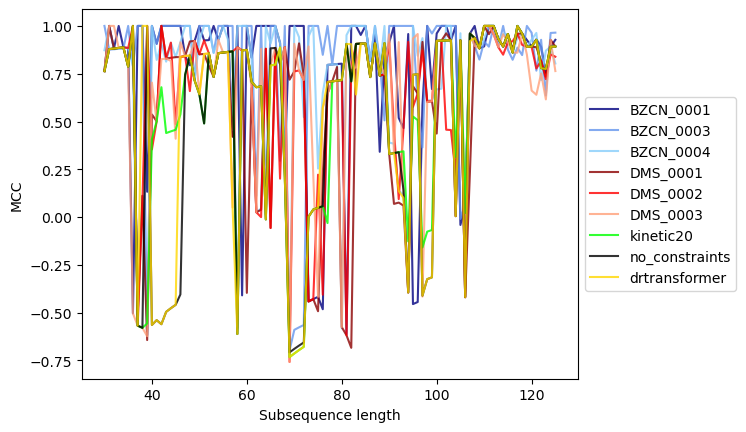

In [232]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'kinetic20' : 'lime', 
        'drtransformer' : 'gold',
        'no_constraints' : 'black'}

fig, ax = plt.subplots()
#for n, d in [it for it in list(shape_data.items()) if it[0] != 'no_constraints']:
for n, d in [it for it in list(shape_data.items()) if it[0] != 'BZCN_0002']: #0002 is the most similar to the other BZCNs
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data['BZCN_0002'][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

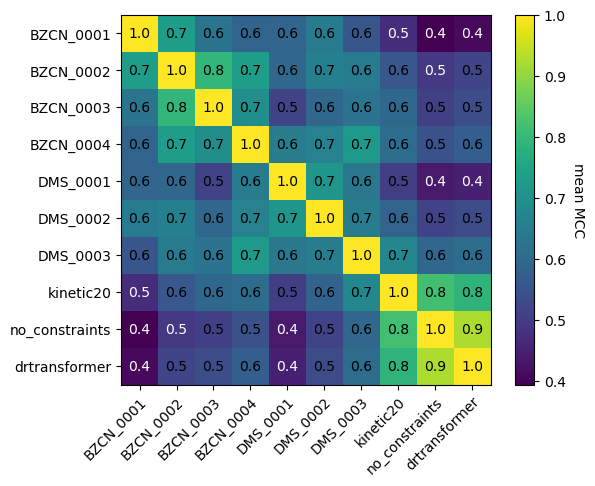

In [178]:
# plot mean MCC between different methods
fig, ax = plt.subplots()
corr = np.ones((len(shape_data.keys()), len(shape_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())), list(shape_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [179]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        step_info = {
                'last' : dict_dot_bracket(last_structure),
                'penalty' : int(p)
            }
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)

        pred_at_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [180]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [181]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.553	0.741	0.623
10	0.541	0.733	0.613
15	0.541	0.733	0.613
20	0.550	0.754	0.626
25	0.533	0.729	0.607
30	0.483	0.672	0.554
35	0.469	0.658	0.540
40	0.469	0.658	0.540
45	0.469	0.658	0.540
50	0.461	0.649	0.531
55	0.449	0.638	0.520
60	0.420	0.581	0.480
65	0.519	0.656	0.570
70	0.512	0.652	0.565
75	0.504	0.643	0.556
80	0.470	0.602	0.519
85	0.470	0.602	0.519
90	0.460	0.593	0.510
95	0.460	0.593	0.510
100	0.442	0.575	0.492

Best!
bzcn:	penalty=5 MCC=0.553
dms:	penalty=20 MCC=0.754
all:	penalty=20 MCC=0.626


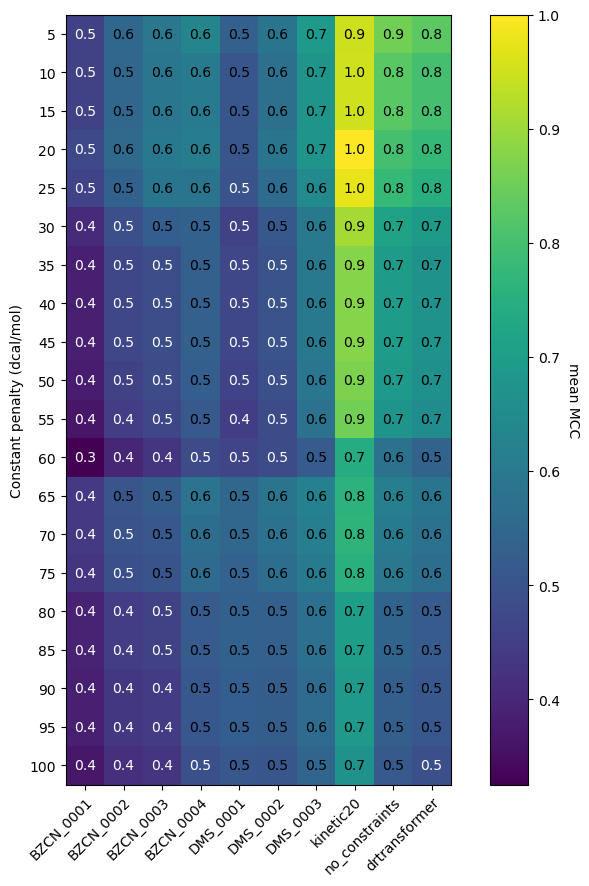

In [182]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [183]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        fc = RNA.fold_compound(subseq, md)
        if last_structure != '':
            fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
            penalty_dict = get_penalties(last_structure, fc_last)
            p_list.extend([v for v in penalty_dict.values()])
        else:
            penalty_dict = {}
        step_info = {
            'last_dict' : dict_dot_bracket(last_structure),
            'penalty_dict' : penalty_dict,
            'penalty_percent' : p
            }
        fc.sc_add_f(penalize_barriers_seq)
        fc.sc_add_data(step_info)

        pred_at_cent[p][length] = fc.mfe()[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 9
Working on percentage = 0.034; mean penalty = 14
Working on percentage = 0.046; mean penalty = 19
Working on percentage = 0.058; mean penalty = 24
Working on percentage = 0.070; mean penalty = 29
Working on percentage = 0.082; mean penalty = 34
Working on percentage = 0.094; mean penalty = 39
Working on percentage = 0.106; mean penalty = 44
Working on percentage = 0.118; mean penalty = 49
Working on percentage = 0.130; mean penalty = 54
Working on percentage = 0.142; mean penalty = 59
Working on percentage = 0.154; mean penalty = 64
Working on percentage = 0.166; mean penalty = 69
Working on percentage = 0.178; mean penalty = 74
Working on percentage = 0.190; mean penalty = 79
Working on percentage = 0.202; mean penalty = 84
Working on percentage = 0.214; mean penalty = 89
Working on percentage = 0.226; mean penalty = 94
Working on percentage = 0.238; mean penalty = 99
Working on percentage 

In [184]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [185]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.553	0.741	0.623
0.022	0.551	0.743	0.623
0.034	0.559	0.757	0.633
0.046	0.559	0.757	0.633
0.058	0.550	0.754	0.626
0.070	0.533	0.729	0.607
0.082	0.532	0.728	0.606
0.094	0.469	0.658	0.540
0.106	0.469	0.658	0.540
0.118	0.461	0.650	0.532
0.130	0.461	0.650	0.532
0.142	0.461	0.650	0.532
0.154	0.420	0.581	0.480
0.166	0.519	0.656	0.570
0.178	0.513	0.652	0.565
0.190	0.505	0.643	0.557
0.202	0.475	0.608	0.525
0.214	0.475	0.608	0.525
0.226	0.475	0.608	0.525
0.238	0.475	0.608	0.525
0.250	0.467	0.599	0.516

Best!
bzcn:	penalty=0.034 MCC=0.559
dms:	penalty=0.034 MCC=0.757
all:	penalty=0.034 MCC=0.633


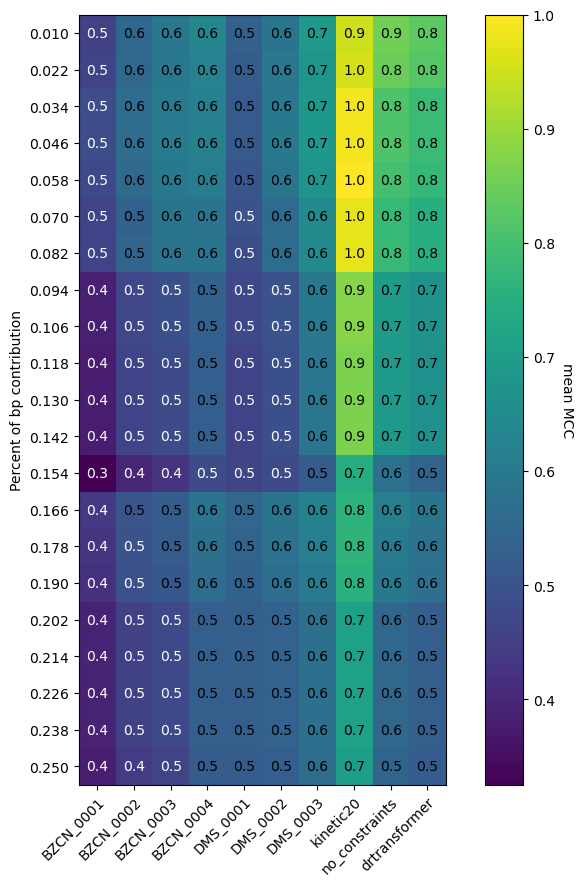

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [187]:
#p = .5
#last_structure = ''
#for length in shape_data['kinetic20'].keys():
#    subseq = shape_data['kinetic20'][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [188]:
# Let's see how this compares with hierarchical folding
# The problem here is that I have even less of a 'ground truth' in this case
pred_at_span_pen = {}
full_seq = shape_data['kinetic20'][list(shape_data['kinetic20'].keys())[-1]]['seq']

for p in penalties:
    print("working on penalty =", p)
    pred_at_span_pen[p] = {}
    last_structure = ''
    for length in shape_data['kinetic20'].keys():
        mds = RNA.md()
        mds.temperature = 37
        mds.max_bp_span = length
        step_info = {
            'last' : dict_dot_bracket(last_structure),
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(full_seq, mds)
        fc.sc_add_f(penalize_barriers)
        fc.sc_add_data(step_info)
        pred_at_span_pen[p][length] = fc.mfe()[0]
        last_structure = pred_at_span_pen[p][length]


working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [189]:
span_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        span_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_span_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_span_pen[5].keys())])

In [190]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(span_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.333	0.455	0.379
0.022	0.334	0.457	0.380
0.034	0.334	0.457	0.380
0.046	0.241	0.384	0.295
0.058	0.265	0.384	0.309
0.070	0.265	0.384	0.309
0.082	0.265	0.383	0.309
0.094	0.271	0.395	0.317
0.106	0.271	0.395	0.317
0.118	0.271	0.395	0.317
0.130	0.251	0.367	0.295
0.142	0.217	0.332	0.260
0.154	0.072	0.182	0.113
0.166	0.072	0.182	0.113
0.178	0.072	0.182	0.113
0.190	0.072	0.182	0.113
0.202	-0.054	0.057	-0.012
0.214	-0.054	0.057	-0.012
0.226	-0.054	0.057	-0.012
0.238	-0.054	0.057	-0.012

Best!
bzcn:	penalty=0.022 MCC=0.334
dms:	penalty=0.022 MCC=0.457
all:	penalty=0.022 MCC=0.380


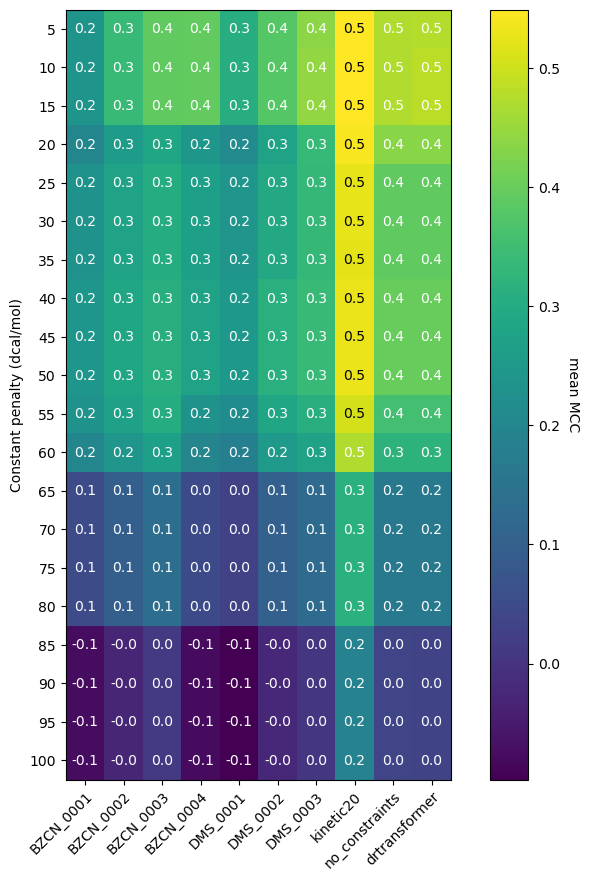

In [191]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(span_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(span_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(span_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(span_penalty_sweep[i, j]), **kw)

In [223]:
# And finally, let's try penalties based on ensemble folding of the structure.
pred_at_ens_pen = {}

for p in penalties:
    print("working on penalty =", p)
    pred_at_ens_pen[p] = {}
    last_ensemble = []
    for length in shape_data['kinetic20'].keys():
        subseq = shape_data['kinetic20'][length]['seq']
        if last_ensemble != []:
            last_freqs = pairing_frequency(last_ensemble)
        else:
            last_freqs = np.zeros(len(subseq))

        freqs = np.zeros(len(subseq))
        freqs[:len(last_freqs)] = last_freqs
        
        step_info = {
            'freqs' : freqs,
            'penalty' : int(p)
        }
        fc = RNA.fold_compound(subseq, mds)
        fc.sc_add_f(penalize_barriers_ensemble)
        fc.sc_add_data(step_info)
        competing = fc.subopt(500)
        last_ensemble = competing
        pred_at_ens_pen[p][length] = last_ensemble[0].structure

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [224]:
ens_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        ens_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_pen[5].keys())])

In [225]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5.000	0.480	0.607	0.528
10.000	0.480	0.607	0.528
15.000	0.468	0.588	0.513
20.000	0.465	0.571	0.505
25.000	0.454	0.548	0.489
30.000	0.462	0.541	0.492
35.000	0.450	0.528	0.479
40.000	0.427	0.511	0.458
45.000	0.425	0.504	0.455
50.000	0.383	0.453	0.409
55.000	0.379	0.436	0.400
60.000	0.368	0.423	0.388
65.000	0.369	0.426	0.390
70.000	0.374	0.467	0.409
75.000	0.380	0.495	0.423
80.000	0.347	0.456	0.388
85.000	0.307	0.422	0.350
90.000	0.311	0.425	0.354
95.000	0.241	0.340	0.278
100.000	0.145	0.209	0.169

Best!
bzcn:	penalty=5.000 MCC=0.480
dms:	penalty=5.000 MCC=0.607
all:	penalty=5.000 MCC=0.528


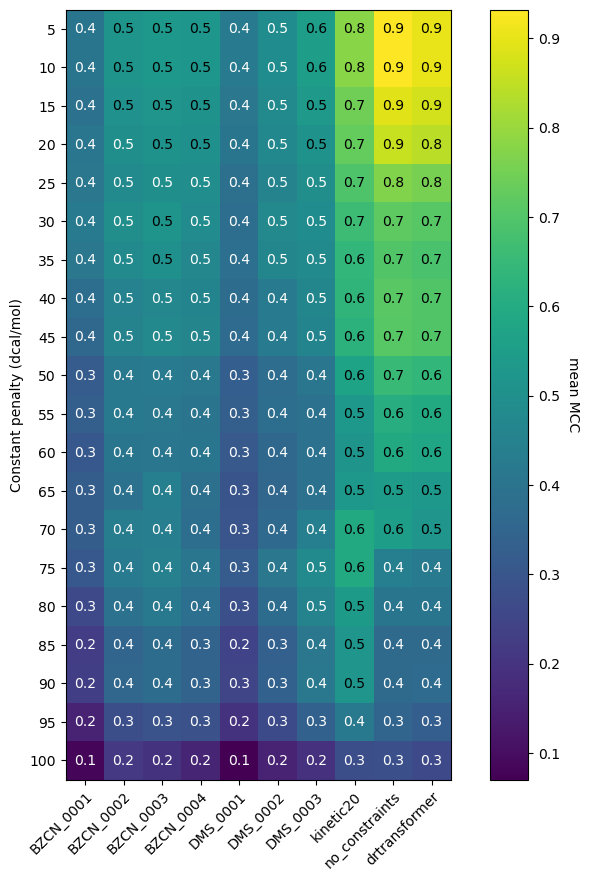

In [226]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_penalty_sweep[i, j]), **kw)

In [ ]:
mfe_percent = []
e_range = np.arange(50, 1050, 50)
for e in e_range:
    e = int(e)
    fc = RNA.fold_compound(full_seq, md)
    competing = fc.subopt(e)
    energies = np.array([c.energy for c in competing])
    energies *= -1 * 1.624
    mfe_percent.append(np.exp(energies[0]) / np.sum(np.exp(energies)))


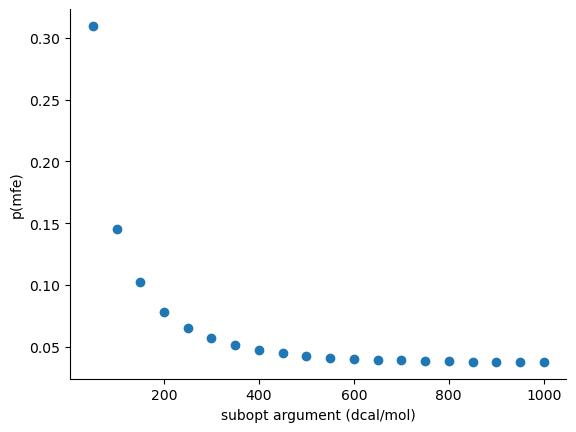

In [219]:
fig, ax = plt.subplots()
ax.scatter(e_range, mfe_percent)
ax.set_ylabel('p(mfe)')
ax.set_xlabel('subopt argument (dcal/mol)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [211]:
mfe_percent[-1]

0.03758974310717898

In [227]:
mfe_percent[9]

0.0424710503359759

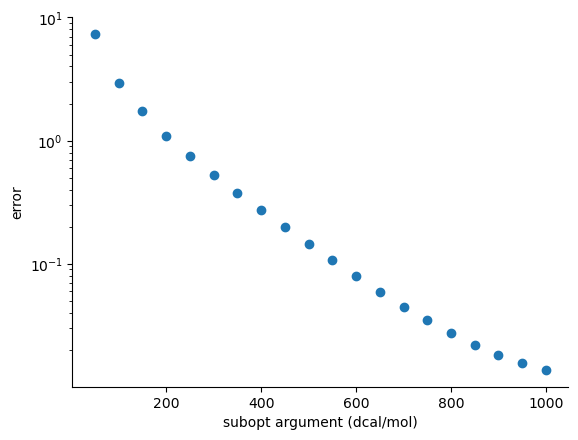

In [231]:
real = 0.0370808

error = [(m - real)/real for m in mfe_percent]
fig, ax = plt.subplots()
ax.scatter(e_range, error)
ax.set_ylabel('error')
ax.set_yscale('log')
ax.set_xlabel('subopt argument (dcal/mol)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()